In [117]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import numpy as np
import seaborn as sns
import datetime as dt
import cufflinks as cf
from IPython.display import display, HTML
from sodapy import Socrata
import streamlit as st
import mysql.connector
import datetime
import time
from googletrans import Translator

from sqlalchemy import create_engine
from googletrans import Translator
from pathlib import Path
import csv
import os

In [64]:
def calidaDato (data):
    df = data
    calidad = []
    mascara = df.isna().sum()
    for i in range(0,len(mascara)):
        p = (df.shape[0]- mascara[i]) / df.shape[0]
        calidad.append([mascara.index[i], round((p*100),2)])
   
    calidad = pd.DataFrame(calidad)
    calidad.rename(columns={0:'Columna', 1: 'Calida %'}, inplace=True)
    
    return calidad

In [110]:
def renombracol(data):
    data = data
    translator = Translator()
    for i in data.columns:
        b = i.replace('_',' ')
        data.rename(columns={i:b}, inplace=True)
        data.rename(columns={'owner':'owne'}, inplace=True)
        
    for i in data.columns:
        data.rename(columns={i:translator.translate(i, dest="es").text.title()}, inplace=True)
        
    return data

In [93]:
def subircsv(nomcarpeta, nomarchivo, extencion, df):
    df = df
    filepath = Path(nomcarpeta + '/' + nomarchivo +'.' + extencion)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath)  

In [192]:
data02 = pd.read_csv('D:\ProyectoFinal\dataset\global_power_plant_database.csv', sep=',', low_memory=False, encoding='latin-1')

In [ ]:
calidad = calidaDato(data02)
calidad

In [193]:
data = renombracol(data02)

In [194]:
data.columns

Index(['País', 'País Largo', 'Nombre', 'Gppd Idnr', 'Capacidad Mw', 'Latitud',
       'Longitud', 'Combustible Principal', 'Otro Combustible1',
       'Otro Combustible2', 'Otro Combustible3', 'Año De Puesta En Marcha',
       'Ser Propietario', 'Fuente', 'Url', 'Fuente De Geolocalización',
       'Id De Wepp', 'Año De Datos De Capacidad', 'Generación Gwh 2013',
       'Generación Gwh 2014', 'Generación Gwh 2015', 'Generación Gwh 2016',
       'Generación Gwh 2017', 'Generación Gwh 2018', 'Generación Gwh 2019',
       'Fuente De Datos De Generación', 'Gwh De Generación Estimada 2013',
       'Gwh De Generación Estimada 2014', 'Gwh De Generación Estimada 2015',
       'Gwh De Generación Estimada 2016', 'Gwh De Generación Estimada 2017',
       'Nota De Generación Estimada 2013', 'Nota De Generación Estimada 2014',
       'Nota De Generación Estimada 2015', 'Nota De Generación Estimada 2016',
       'Nota De Generación Estimada 2017'],
      dtype='object')

In [195]:
tabla_global_planta_energia = data[['País', 'País Largo', 'Combustible Principal']]
tabla_global_planta_energia = tabla_global_planta_energia.drop_duplicates()


In [77]:
from pathlib import Path  
filepath = Path('TablasNormal/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)  

In [196]:
tabla_global_planta_energia['cant'] = 1 #unidad por dato

In [198]:
tabla_global_planta_energia.head(1)

,País,País Largo,Combustible Principal,cant
0,AFG,Afghanistan,Hydro,1


In [199]:
tabla_global_planta_energia['Id'] = format(id(tabla_global_planta_energia['País']), 'x')

In [201]:
tabla_global_planta_energia.set_index('Id', inplace=True)
tabla_global_planta_energia = tabla_global_planta_energia.reset_index()

In [202]:
subircsv('TablasNormal', 'Master_global_anergia', 'csv', tabla_global_planta_energia)

In [203]:
Master_global_anergia = tabla_global_planta_energia.groupby('Combustible Principal')['cant'].sum() # cantidad por energia primaria 
Master_global_anergia = Master_global_anergia.reset_index()

In [204]:
Master_global_anergia['Participacion'] = (Master_global_anergia['cant'] / Master_global_anergia.cant.sum()) * 100

In [205]:
Master_global_anergia['Id_tipoEnerg'] = format(id(Master_global_anergia['Combustible Principal']), 'x')

In [207]:
Master_global_anergia.set_index('Id_tipoEnerg', inplace=True)
Master_global_anergia = Master_global_anergia.reset_index()

In [208]:
Master_global_anergia

,Id_tipoEnerg,Combustible Principal,cant,Participacion
0,1f08496b3a0,Biomass,38,5.444126
1,1f08496b3a0,Coal,74,10.601719
2,1f08496b3a0,Cogeneration,2,0.286533
3,1f08496b3a0,Gas,113,16.189112
4,1f08496b3a0,Geothermal,22,3.151862
5,1f08496b3a0,Hydro,128,18.338109
6,1f08496b3a0,Nuclear,31,4.441261
7,1f08496b3a0,Oil,105,15.042980
8,1f08496b3a0,Other,9,1.289398
9,1f08496b3a0,Petcoke,2,0.286533


In [209]:
subircsv('TablasNormal', 'Master_tipo_energia', 'csv', Master_global_anergia)

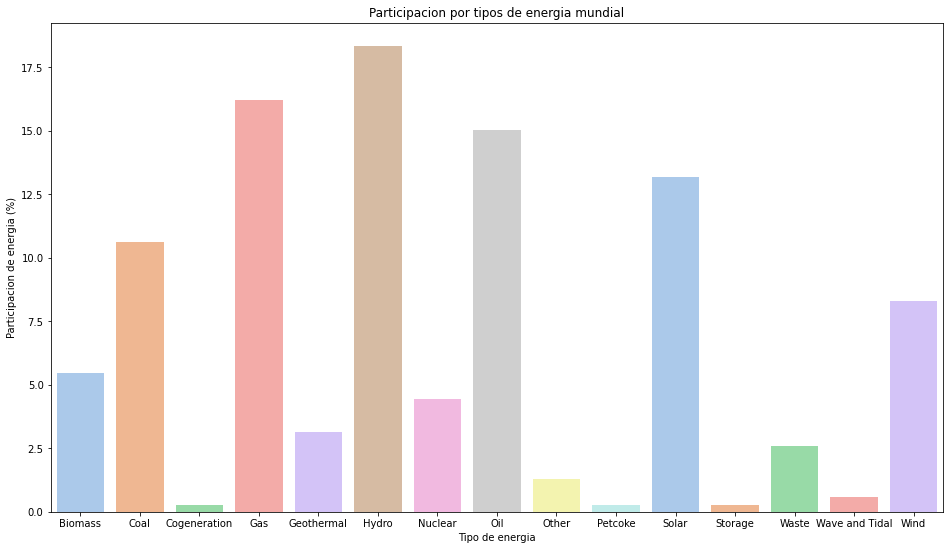

In [91]:
plt.figure(figsize=(16,9))
sns.barplot(data=Master_global_anergia, x="Combustible Principal", y="Participacion", palette='pastel')
plt.title('Participacion por tipos de energia mundial')
plt.xlabel('Tipo de energia')
plt.ylabel('Participacion de energia (%)')
plt.show()

In [179]:
dataco2 = pd.read_csv('D:\emissionsmap\documentation\data\energyco2.csv', sep=',', low_memory=False, encoding='latin-1')

In [180]:
dataco2 = dataco2.drop(['Unnamed: 0'], axis=1)

In [181]:
renombracol(dataco2) #renobrado columna

,País,Tipo De Energía,Año,Consumo De Energía,Producción De Energía,Pib,Población,Intensidad De Energía Per Cápita,Intensidad De Energía Por Pib,Emisión De Co2
0,World,all_energy_types,1980,292.899790,296.337228,27770.910281,4.298127e+06,68.145921,10.547000,4946.627130
1,World,coal,1980,78.656134,80.114194,27770.910281,4.298127e+06,68.145921,10.547000,1409.790188
2,World,natural_gas,1980,53.865223,54.761046,27770.910281,4.298127e+06,68.145921,10.547000,1081.593377
3,World,petroleum_n_other_liquids,1980,132.064019,133.111109,27770.910281,4.298127e+06,68.145921,10.547000,2455.243565
4,World,nuclear,1980,7.575700,7.575700,27770.910281,4.298127e+06,68.145921,10.547000,0.000000
...,...,...,...,...,...,...,...,...,...,...
55435,Zimbabwe,coal,2019,0.045064,0.075963,37.620400,1.465420e+04,11.508701,4.482962,4.586869
55436,Zimbabwe,natural_gas,2019,0.000000,0.000000,37.620400,1.465420e+04,11.508701,4.482962,0.000000
55437,Zimbabwe,petroleum_n_other_liquids,2019,0.055498,0.000000,37.620400,1.465420e+04,11.508701,4.482962,4.377890
55438,Zimbabwe,nuclear,2019,NaN,NaN,37.620400,1.465420e+04,11.508701,4.482962,0.000000


In [182]:
dataco2.head(1)

,País,Tipo De Energía,Año,Consumo De Energía,Producción De Energía,Pib,Población,Intensidad De Energía Per Cápita,Intensidad De Energía Por Pib,Emisión De Co2
0,World,all_energy_types,1980,292.89979,296.337228,27770.910281,4.298127e+06,68.145921,10.547,4946.62713


In [183]:
dataco2['Id'] = format(id(dataco2['Año']), 'x')

In [190]:
dataco2.head(1)

,Id,País,Tipo De Energía,Año,Consumo De Energía,Producción De Energía,Pib,Población,Intensidad De Energía Per Cápita,Intensidad De Energía Por Pib,Emisión De Co2
0,1f0848c6a10,World,all_energy_types,1980,292.89979,296.337228,27770.910281,4.298127e+06,68.145921,10.547,4946.62713


In [186]:
dataco2.set_index('Id', inplace=True)
dataco2 = dataco2.reset_index()

In [191]:
subircsv('TablasNormal', 'Master_global_co2', 'csv', dataco2)

In [214]:
dataco2['Tipo De Energía'].unique()

array(['all_energy_types', 'coal', 'natural_gas',
       'petroleum_n_other_liquids', 'nuclear', 'renewables_n_other'],
      dtype=object)

In [215]:
Master_global_anergia

,Id_tipoEnerg,Combustible Principal,cant,Participacion
0,1f08496b3a0,Biomass,38,5.444126
1,1f08496b3a0,Coal,74,10.601719
2,1f08496b3a0,Cogeneration,2,0.286533
3,1f08496b3a0,Gas,113,16.189112
4,1f08496b3a0,Geothermal,22,3.151862
5,1f08496b3a0,Hydro,128,18.338109
6,1f08496b3a0,Nuclear,31,4.441261
7,1f08496b3a0,Oil,105,15.042980
8,1f08496b3a0,Other,9,1.289398
9,1f08496b3a0,Petcoke,2,0.286533
